In [2]:
library(feasts)
library(tsibble)
library(dplyr)
library(ggplot2)
library(scales)
library(forecast)
library(tseries)
library(gridExtra)
library(showtext)
# 載入必要的套件
library(reticulate)
library(randomForest)
# 用於 XGBoost 回歸模型
library(xgboost)  
# 啟用 wqy-microhei 字型
showtext_auto()

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




讀取再生能源資料，並可視化數據

In [11]:
data <- read.csv('RenewableEnergy_mon.csv')
head(data)
tail(data)

,日期.年.月.,單位,再生能源發電量合計,慣常水力,地熱,太陽光電,風力_小計,風力_陸域,風力_離岸,生質能_小計,生質能_固態,生質能_氣態,廢棄物
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,200501,千度,494319.0,186435.9,0,60,5168.283,5168.283,0,32737.84,27301.57,5436.270,269917.0
2,200502,千度,512961.3,236004.4,0,68,3869.487,3869.487,0,30183.47,25443.84,4739.630,242836.0
3,200503,千度,757503.8,457365.3,0,71,3570.914,3570.914,0,31671.52,26104.84,5566.680,264825.0
4,200504,千度,651535.7,392454.0,0,74,3254.841,3254.841,0,28838.33,23810.35,5027.979,226914.4
5,200505,千度,603102.4,365667.2,0,74,3967.358,3967.358,0,22621.18,17358.26,5262.920,210772.7
6,200506,千度,753000.0,450256.5,0,75,5498.623,5498.623,0,25522.01,20286.65,5235.360,271647.9


,日期.年.月.,單位,再生能源發電量合計,慣常水力,地熱,太陽光電,風力_小計,風力_陸域,風力_離岸,生質能_小計,生質能_固態,生質能_氣態,廢棄物
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
233,202405,千度,2402063,247072.6,2257.367,1190337,646919.4,100818.48,546100.9,12859.54,8326.372,4533.167,302617.7
234,202406,千度,2849626,426414.6,1828.395,1541909,563227.7,96661.99,466565.7,16654.34,12468.439,4185.899,299591.9
235,202407,千度,2745089,469469.0,1938.981,1545098,385387.5,71113.47,314274.1,19478.69,14967.819,4510.869,323716.0
236,202408,千度,2920943,641790.0,2170.359,1640080,301255.0,45065.42,256189.6,19332.74,15089.895,4242.844,316315.2
237,202409,千度,2626665,365394.9,2221.700,1483845,444857.6,59597.06,385260.6,18270.24,14999.515,3270.729,312075.6
238,202410,千度,3264459,469585.2,2272.901,1295351,1185286.6,224776.50,960510.1,19713.44,16528.491,3184.948,292249.8


繪製所有數據的時間序列圖

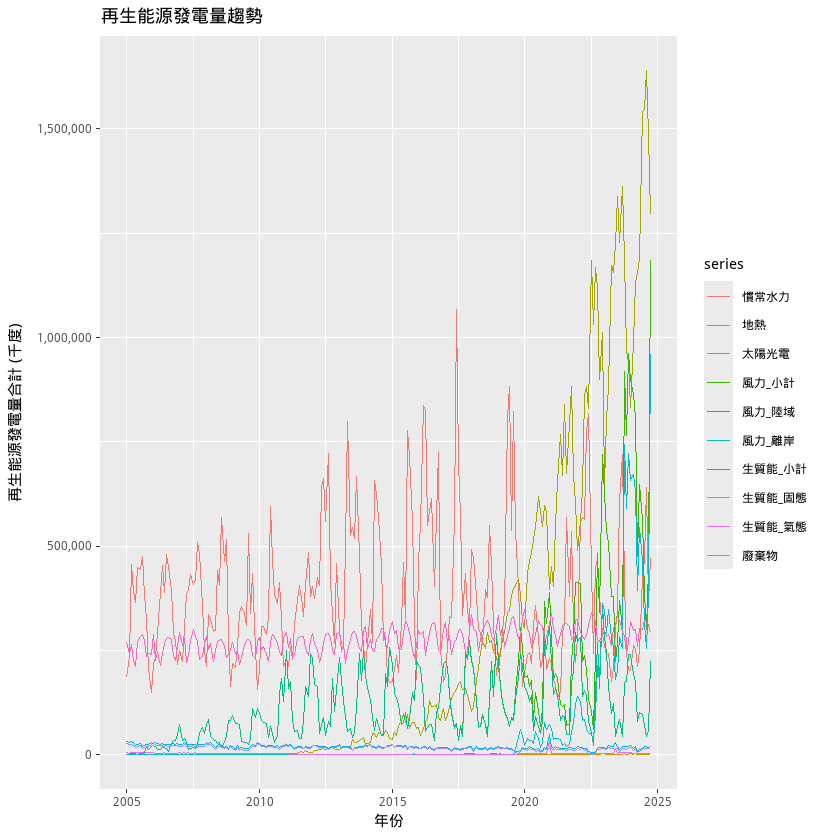

In [4]:

my1 <- ts(data[, -c(1:3)], start = c(2005, 1), frequency = 12)
max_y <- ceiling(max(data[, -c(1:3)], na.rm = TRUE) / 500000) * 500000
my1 %>%
  autoplot() +
  ylab("再生能源發電量合計 (千度)") +
  xlab("年份") +
  ggtitle("再生能源發電量趨勢") +
  scale_y_continuous(
    breaks = seq(0, max_y, by = 500000),  # 設定 Y 軸間隔為 50,000，最大到 1,500,000
    labels = scales::comma                # 格式化刻度為千分位顯示
  ) +
  theme_gray(base_family = "wqy-microhei")


查看摘要並挑選三個數值較高的數據

In [5]:
summary(data)

  日期.年.月.         單位           再生能源發電量合計    慣常水力      
 Min.   :200501   Length:238         Min.   : 440985    Min.   : 138709  
 1st Qu.:200934   Class :character   1st Qu.: 722079    1st Qu.: 253565  
 Median :201412   Mode  :character   Median : 890257    Median : 340530  
 Mean   :201448                      Mean   :1100345    Mean   : 380612  
 3rd Qu.:201911                      3rd Qu.:1254160    3rd Qu.: 465522  
 Max.   :202410                      Max.   :3264459    Max.   :1067642  
      地熱            太陽光電         風力_小計         風力_陸域     
 Min.   :   0.00   Min.   :     60   Min.   :   2510   Min.   :  2510  
 1st Qu.:   0.00   1st Qu.:   1107   1st Qu.:  51539   1st Qu.: 47579  
 Median :   0.00   Median :  51102   Median : 100747   Median : 84608  
 Mean   : 344.34   Mean   : 260072   Mean   : 161898   Mean   :109012  
 3rd Qu.:  63.74   3rd Qu.: 393571   3rd Qu.: 209824   3rd Qu.:160735  
 Max.   :2922.46   Max.   :1640080   Max.   :1185287   Max.   :358570  
   風力_離岸   

將水力、太陽能、風力的時間序列圖個別顯示

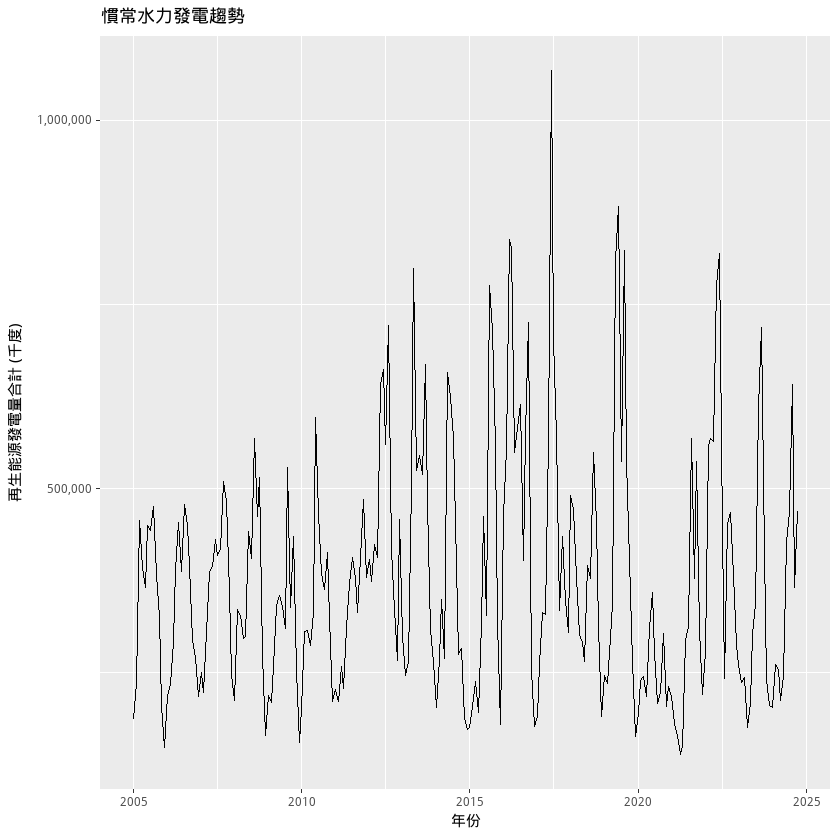

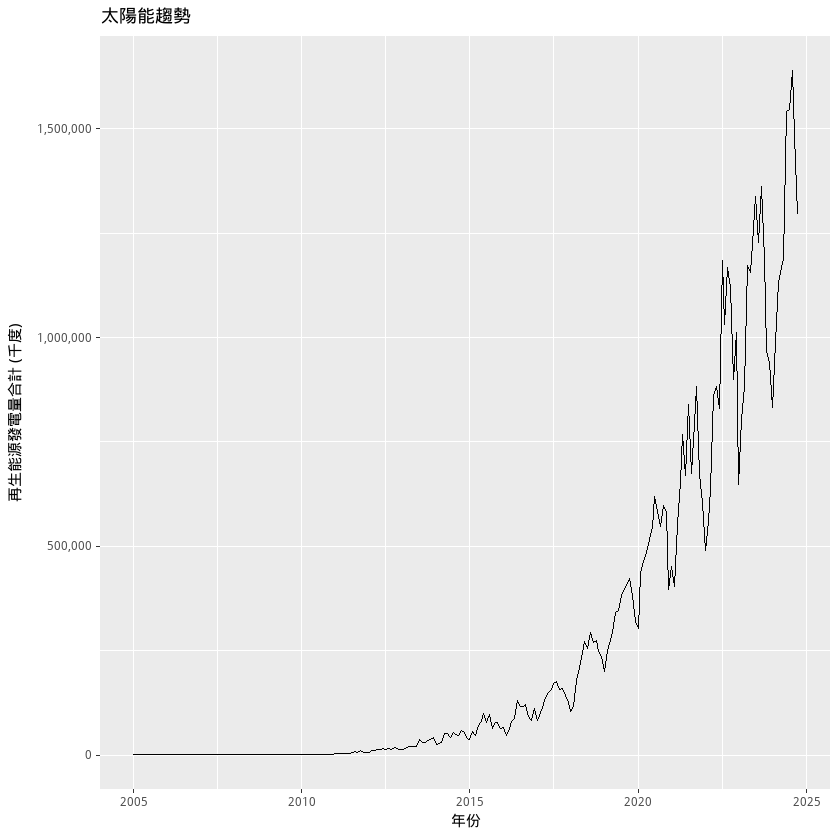

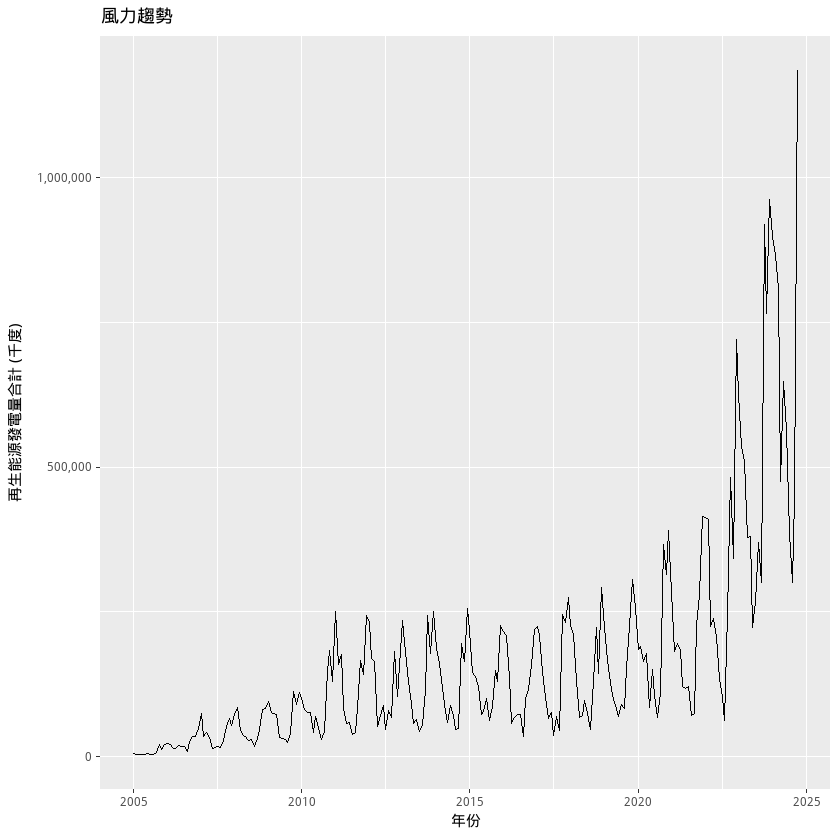

In [6]:
hydroelectricity1 <- ts(data[, 4], start = c(2005, 1), frequency = 12)
max_y1 <- ceiling(max(data[, 4], na.rm = TRUE) / 500000) * 500000
hydroelectricity2 <- ts(data[, 6], start = c(2005, 1), frequency = 12)
max_y2 <- ceiling(max(data[, 6], na.rm = TRUE) / 500000) * 500000
hydroelectricity3 <- ts(data[, 7], start = c(2005, 1), frequency = 12)
max_y3<- ceiling(max(data[, 7], na.rm = TRUE) / 500000) * 500000

hydroelectricity1 %>%
  autoplot() +
  ylab("再生能源發電量合計 (千度)") +
  xlab("年份") +
  ggtitle("慣常水力發電趨勢") +
  scale_y_continuous(
    breaks = seq(0, max_y, by = 500000),
    labels = scales::comma
  ) +
  theme_gray(base_family = "wqy-microhei")

hydroelectricity2 %>%
  autoplot() +
  ylab("再生能源發電量合計 (千度)") +
  xlab("年份") +
  ggtitle("太陽能趨勢") +
  scale_y_continuous(
    breaks = seq(0, max_y, by = 500000),
    labels = scales::comma
  ) +
  theme_gray(base_family = "wqy-microhei")  

hydroelectricity3 %>%
  autoplot() +
  ylab("再生能源發電量合計 (千度)") +
  xlab("年份") +
  ggtitle("風力趨勢") +
  scale_y_continuous(
    breaks = seq(0, max_y, by = 500000),
    labels = scales::comma
  ) +
  theme_gray(base_family = "wqy-microhei")  


In [7]:
# 導入 TensorFlow 和 Keras
tf <- import("tensorflow")
keras <- tf$keras
# 定義滴後數據處理函數
create_lagged_data <- function(data, lags) {
  df <- as.data.frame(matrix(NA, nrow = length(data), ncol = lags + 1))
  colnames(df) <- c("y", paste0("lag", 1:lags))
  df$y <- data
  for (i in 1:lags) {
    df[, i + 1] <- c(rep(NA, i), head(data, -i))
  }
  return(na.omit(df))
}

2005年到2023年的數據用來訓練模型 </br>
預測2024年的數據

水力-準確性指標:
ME  : 0.2314113 
RMSE: 1.674753 
MAE : 0.9184841 
MAPE: 0.0002636431 


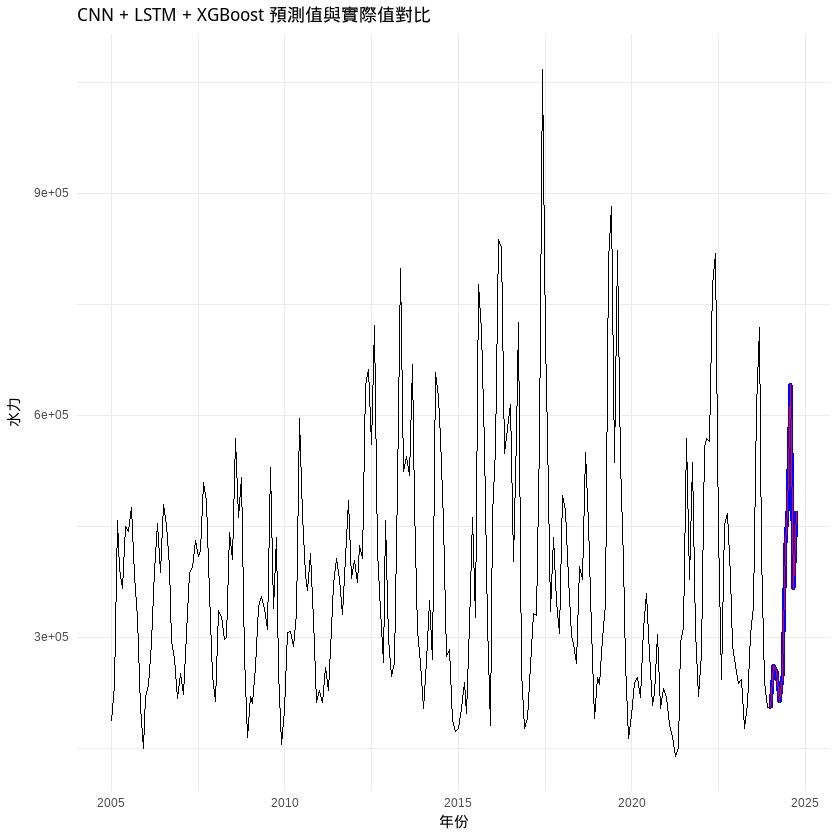

In [12]:
# 數據處理：使用轉換後的時間序列
train_data <- window(hydroelectricity1, end = c(2023, 12))
test_data <- window(hydroelectricity1, start = c(2024, 1))

# 滴後數據處理
train_df <- create_lagged_data(as.numeric(train_data), lags = 12)
test_df <- create_lagged_data(as.numeric(c(tail(train_data, 12), test_data)), lags = 12)

# 標準化數據
train_means <- colMeans(train_df)
train_sds <- apply(train_df, 2, sd)
train_df_scaled <- as.data.frame(scale(train_df, center = train_means, scale = train_sds))
test_df_scaled <- as.data.frame(scale(test_df, center = train_means, scale = train_sds))

# 分離特徵與目標變量
x_train <- array(as.matrix(train_df_scaled[, -1]), dim = c(nrow(train_df_scaled), 12, 1))
y_train <- train_df_scaled$y
x_test <- array(as.matrix(test_df_scaled[, -1]), dim = c(nrow(test_df_scaled), 12, 1))
y_test <- test_df_scaled$y

# 檢查數據類型並轉換為 float32
x_train <- tf$convert_to_tensor(x_train, dtype = tf$float32)
y_train <- tf$convert_to_tensor(y_train, dtype = tf$float32)
x_test <- tf$convert_to_tensor(x_test, dtype = tf$float32)
y_test <- tf$convert_to_tensor(y_test, dtype = tf$float32)

# 構建 CNN + LSTM 模型
model <- keras$Sequential()
# 增加多層 CNN，保留時間步長
model$add(keras$layers$Conv1D(filters = as.integer(64), kernel_size = as.integer(3), activation = "relu", input_shape = c(as.integer(12), as.integer(1))))
model$add(keras$layers$MaxPooling1D(pool_size = as.integer(2)))
model$add(keras$layers$Conv1D(filters = as.integer(128), kernel_size = as.integer(2), activation = "relu"))
model$add(keras$layers$MaxPooling1D(pool_size = as.integer(1)))
# 第一層 LSTM
model$add(keras$layers$LSTM(units = as.integer(200), return_sequences = TRUE))
model$add(keras$layers$Dropout(rate = 0.3))
# 第二層 LSTM
model$add(keras$layers$LSTM(units = as.integer(100)))
model$add(keras$layers$Dropout(rate = 0.3))
# Dense 層
model$add(keras$layers$Dense(units = as.integer(64), activation = "relu"))
model$add(keras$layers$Dense(units = as.integer(1)))


# 編輯模型
model$compile(
  loss = "huber",  # 使用 Huber 損失
  optimizer = keras$optimizers$Adam(learning_rate = 0.0005),
  metrics = list("mae")
)

# 訓練 CNN + LSTM 模型
history <- model$fit(
  x_train, y_train,
  epochs = as.integer(50),
  batch_size = as.integer(16),
  validation_data = tuple(x_test, y_test),
  verbose = 1L
)

# 使用 CNN + LSTM 模型進行預測
y_pred_scaled <- model$predict(x_test)

# 反標準化預測結果
y_pred <- as.vector(y_pred_scaled) * train_sds[1] + train_means[1]
y_test_rescaled <- y_test * train_sds[1] + train_means[1]
y_test_rescaled <- y_test_rescaled$numpy()

# 計算残差
residuals <- y_test_rescaled - y_pred

# 使用 XGBoost 修正残差
# 準備數據
dtrain <- xgb.DMatrix(data = as.matrix(test_df_scaled[, -1]), label = residuals)

# 訓練 XGBoost 模型
xgb_model <- xgboost(
  data = dtrain,
  nrounds = 200,
  max_depth = 6,
  eta = 0.1,
  objective = "reg:squarederror",
  verbose = 0
)

# 預測残差
xgb_residuals <- predict(xgb_model, newdata = as.matrix(test_df_scaled[, -1]))

# 修正 CNN + LSTM 預測結果
final_predictions <- y_pred + xgb_residuals

# 確保預測值和實際值為時間序列格式
nn_rf_forecast <- ts(final_predictions, start = c(2024, 1), frequency = 12)
test_actual <- ts(y_test_rescaled, start = c(2024, 1), frequency = 12)

# 調整測試數據以避免 MAPE 計算出錯
adjusted_test_actual <- test_actual
adjusted_test_actual[adjusted_test_actual == 0] <- 1e-5

# 手動計算準確性指標
me <- mean(nn_rf_forecast - test_actual, na.rm = TRUE)
rmse <- sqrt(mean((nn_rf_forecast - test_actual)^2, na.rm = TRUE))
mae <- mean(abs(nn_rf_forecast - test_actual), na.rm = TRUE)
mape <- mean(abs((nn_rf_forecast - adjusted_test_actual) / adjusted_test_actual) * 100, na.rm = TRUE)

# 顯示準確性指標
cat("水力-準確性指標:\n")
cat("ME  :", me, "\n")
cat("RMSE:", rmse, "\n")
cat("MAE :", mae, "\n")
cat("MAPE:", mape, "\n")

# 繪製完整的時間序列圖
combined_ts <- ts(c(as.numeric(train_data), as.numeric(test_data)), 
                  start = start(train_data), 
                  frequency = frequency(train_data))

autoplot(combined_ts) +
  autolayer(nn_rf_forecast, series = "改進 CNN + LSTM + XGBoost 預測值", size = 1.2, color = "blue") +
  autolayer(test_actual, series = "實際值", color = "red") +
  ggtitle("CNN + LSTM + XGBoost 預測值與實際值對比") +
  xlab("年份") +
  ylab("水力") +
  theme_minimal()

